In [1]:
# https://www.kaggle.com/competitions/store-sales-time-series-forecasting

In [2]:
import pandas as pd

df = pd.read_csv('data/store-sales-time-series-forecasting/train.csv')
df.shape

(3000888, 6)

In [3]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
df['date'] = pd.to_datetime(df.date)

# Viz

<AxesSubplot:>

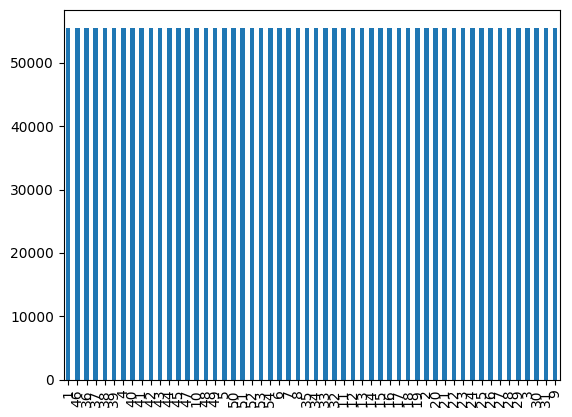

In [5]:
df.store_nbr.value_counts().plot.bar()

<AxesSubplot:xlabel='date'>

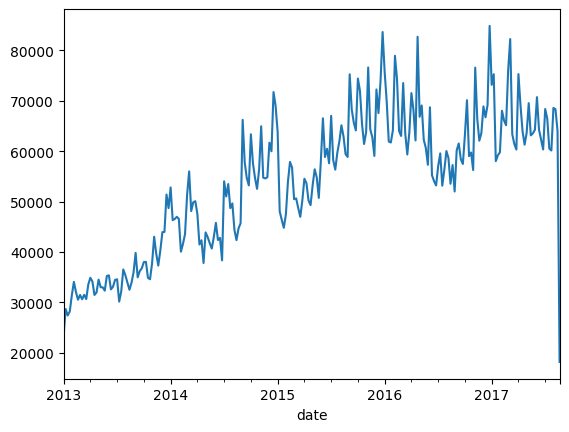

In [6]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

(
    df
    .set_index('store_nbr')
    .loc[df.store_nbr.sample()]
    .resample('W', on='date')
    .sales
    .sum()
).plot(ax=ax)

# Model

In [7]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [8]:
X = (
    df
    .drop('id', axis=1)
    .set_index('date')
    .groupby(['store_nbr', pd.Grouper(freq='D')])
    .sales
    .sum()
    .reset_index()
)

X['t'] = (X.date - X.date.min()).dt.days
X['id'] = X.store_nbr.map({n: i for i, n in enumerate(X.store_nbr.unique())})

X.head()

,store_nbr,date,sales,t,id
0,1,2013-01-01,0.000000,0,0
1,1,2013-01-02,7417.148000,1,0
2,1,2013-01-03,5873.244001,2,0
3,1,2013-01-04,5919.879001,3,0
4,1,2013-01-05,6318.785010,4,0


In [9]:
from ryan_adams import *
from tensorflow import keras

n_items = X.id.nunique()
t_range = X.t.min(), X.t.max()
model = RyanAdams(
    trends=[
        LinearTrend(n_items=1, t_range=t_range, name='global_trend'),
        LinearTrend(n_items=n_items, t_range=t_range, name='local_trend'),
    ],
    seasonalities=[
        Seasonality(n_items=1, period=365.25, order=10, name='gobal_seasonality_yearly'),
        Seasonality(n_items=1, period=7, order=3, name='gobal_seasonality_weekly'),
        Seasonality(n_items=n_items, period=365.25, order=10, name='local_seasonality_yearly'),
        Seasonality(n_items=n_items, period=7, order=3, name='local_seasonality_weekly'),
    ],
    outer_layers=[
        keras.layers.Dense(4, activation='relu'),
        keras.layers.Dense(4, activation='relu'),
        keras.layers.Dense(4, activation='relu'),
    ],
    output_activations='softplus',
)

2023-05-07 18:46:13.986724: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model._model.compile(loss='mse', optimizer='adam', metrics=keras.metrics.RootMeanSquaredError())

In [11]:
import numpy as np
model.fit(
    X[['id', 't']].to_dict('series'), np.log10(X.sales+1),
    batch_size=32,
    epochs=15,
)

Epoch 1/15
2842/2842 [==============================] - 8s 2ms/step - loss: 4.2800 - root_mean_squared_error: 1.0008
Epoch 2/15
2842/2842 [==============================] - 6s 2ms/step - loss: 1.7639 - root_mean_squared_error: 0.6646
Epoch 3/15
2842/2842 [==============================] - 6s 2ms/step - loss: 2.1069 - root_mean_squared_error: 0.7997
Epoch 4/15
2842/2842 [==============================] - 6s 2ms/step - loss: 1.7758 - root_mean_squared_error: 0.6667
Epoch 5/15
2842/2842 [==============================] - 8s 3ms/step - loss: 1.7364 - root_mean_squared_error: 0.6386
Epoch 6/15
2842/2842 [==============================] - 6s 2ms/step - loss: 1.6048 - root_mean_squared_error: 0.5706
Epoch 7/15
2842/2842 [==============================] - 6s 2ms/step - loss: 1.5943 - root_mean_squared_error: 0.5799
Epoch 8/15
2842/2842 [==============================] - 6s 2ms/step - loss: 1.5577 - root_mean_squared_error: 0.5594
Epoch 9/15
2842/2842 [==============================] - 6s 2ms/s

## Predict

15717    9
Name: id, dtype: int64


/Users/dantegates/virtualenvs/v3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


53/53 [==============================] - 1s 1ms/step


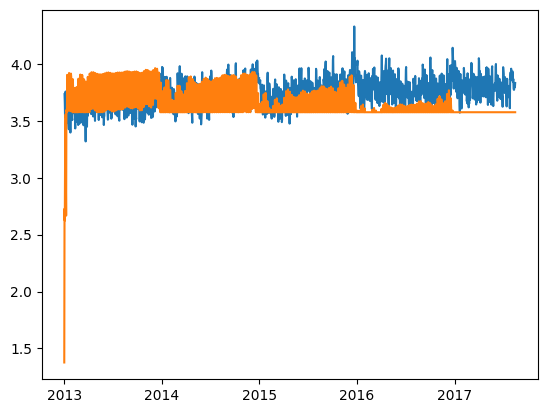

In [12]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()


ix = X.id.sample()
print(ix)
actual = np.log10(
    X
    .set_index('id')
    .loc[ix]
    .set_index('date')
    .sales
)

p = model._model.predict(X.set_index('id').loc[ix].reset_index()[['id', 't']].to_dict('series'))

ax.plot(actual.index, actual)
ax.plot(actual.index, p.ravel())

# Model with Features

In [13]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


## Base Train

In [14]:
X = (
    df
    .drop('id', axis=1)
    .set_index('date')
    .groupby(['store_nbr', pd.Grouper(freq='D')])
    .sales
    .sum()
    .reset_index()
)

X['t'] = (X.date - X.date.min()).dt.days
X['id'] = X.store_nbr.map({n: i for i, n in enumerate(X.store_nbr.unique())})

X.head()

,store_nbr,date,sales,t,id
0,1,2013-01-01,0.000000,0,0
1,1,2013-01-02,7417.148000,1,0
2,1,2013-01-03,5873.244001,2,0
3,1,2013-01-04,5919.879001,3,0
4,1,2013-01-05,6318.785010,4,0


## Oil Prices

In [15]:
oil_prices = pd.read_csv('data/store-sales-time-series-forecasting/oil.csv')
oil_prices['date'] = pd.to_datetime(oil_prices.date)
oil_prices

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [16]:
oil_prices = (
    oil_prices
    .set_index('date')
    .reindex(df.date.unique())
    .dcoilwtico
    .fillna(method='bfill')
)

In [17]:
X.shape

(90936, 5)

In [18]:
X['oil_price'] = X.date.map(oil_prices)
X.head()

,store_nbr,date,sales,t,id,oil_price
0,1,2013-01-01,0.000000,0,0,93.14
1,1,2013-01-02,7417.148000,1,0,93.14
2,1,2013-01-03,5873.244001,2,0,92.97
3,1,2013-01-04,5919.879001,3,0,93.12
4,1,2013-01-05,6318.785010,4,0,93.20


## Store descriptors

In [19]:
stores = pd.read_csv('data/store-sales-time-series-forecasting/stores.csv')
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [20]:
X = X.merge(stores)
X.shape

(90936, 10)

In [21]:
X.head()

,store_nbr,date,sales,t,id,oil_price,city,state,type,cluster
0,1,2013-01-01,0.000000,0,0,93.14,Quito,Pichincha,D,13
1,1,2013-01-02,7417.148000,1,0,93.14,Quito,Pichincha,D,13
2,1,2013-01-03,5873.244001,2,0,92.97,Quito,Pichincha,D,13
3,1,2013-01-04,5919.879001,3,0,93.12,Quito,Pichincha,D,13
4,1,2013-01-05,6318.785010,4,0,93.20,Quito,Pichincha,D,13


## Fit Model

In [22]:
for c in ['city', 'state', 'type', 'cluster']:
    X[c] = X[c].map({c: i for i, c in enumerate(X[c].unique())})

In [23]:
from ryan_adams import *
from tensorflow import keras


def E(*args, **kwargs):
    def wrapper(x):
        return keras.layers.Reshape((1,))(
            keras.layers.Embedding(*args, **kwargs)(x)
        )
    return wrapper

n_items = X.id.nunique()
t_range = X.t.min(), X.t.max()
model_dense = RyanAdams(
    trends=[
        LinearTrend(n_items=1, t_range=t_range, name='global_trend', shared_embedding_projection=True),
        LinearTrend(n_items=n_items, t_range=t_range, name='local_trend', shared_embedding_projection=True),
    ],
    seasonalities=[
        Seasonality(n_items=1, period=365.25, order=10, name='gobal_seasonality_yearly', shared_embedding_projection=True),
        Seasonality(n_items=1, period=7, order=3, name='gobal_seasonality_weekly', shared_embedding_projection=True),
        Seasonality(n_items=n_items, period=365.25, order=10, name='local_seasonality_yearly', shared_embedding_projection=True),
        Seasonality(n_items=n_items, period=7, order=3, name='local_seasonality_weekly', shared_embedding_projection=True),
    ],
    outer_layers=[
        keras.layers.BatchNormalization(),
        keras.layers.Dense(10, activation='relu'),
        keras.layers.Dense(10, activation='relu'),
    ],
    features={
        'oil_price': lambda x: x,
        'city': E(input_dim=X.city.nunique(), output_dim=1, input_length=1),
        'state': E(input_dim=X.state.nunique(), output_dim=1, input_length=1),
        'type': E(input_dim=X.type.nunique(), output_dim=1, input_length=1),
        'cluster': E(input_dim=X.cluster.nunique(), output_dim=1, input_length=1),
    },
    output_activations='softplus',
)

In [24]:
model_dense._model.compile(loss='mse', optimizer='adam', metrics=keras.metrics.RootMeanSquaredError())

In [25]:
model_dense._model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 city (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 state (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 type (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 cluster (InputLayer)           [(None, 1)]          0           []                               
                                                                                            

In [26]:
model_dense.fit(
    X[['id', 't', 'oil_price', 'city', 'state', 'type', 'cluster']].to_dict('series'), np.log10(X.sales+1),
    batch_size=32,
    epochs=20
)

Epoch 1/20
2842/2842 [==============================] - 16s 4ms/step - loss: 3.8094 - root_mean_squared_error: 0.9053
Epoch 2/20
2842/2842 [==============================] - 9s 3ms/step - loss: 1.3983 - root_mean_squared_error: 0.4990
Epoch 3/20
2842/2842 [==============================] - 9s 3ms/step - loss: 1.3357 - root_mean_squared_error: 0.4446
Epoch 4/20
2842/2842 [==============================] - 12s 4ms/step - loss: 1.3134 - root_mean_squared_error: 0.4168
Epoch 5/20
2842/2842 [==============================] - 9s 3ms/step - loss: 1.2859 - root_mean_squared_error: 0.3949
Epoch 6/20
2842/2842 [==============================] - 9s 3ms/step - loss: 1.2778 - root_mean_squared_error: 0.3861
Epoch 7/20
2842/2842 [==============================] - 10s 4ms/step - loss: 1.2788 - root_mean_squared_error: 0.3800
Epoch 8/20
2842/2842 [==============================] - 10s 4ms/step - loss: 1.2702 - root_mean_squared_error: 0.3728
Epoch 9/20
2842/2842 [==============================] - 9s 3

## Predict

In [27]:
X['p'] = model_dense.predict(X[['id', 't', 'oil_price', 'city', 'state', 'type', 'cluster']].to_dict('series'))

2842/2842 [==============================] - 6s 2ms/step


89370    53
Name: id, dtype: int64


/Users/dantegates/virtualenvs/v3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


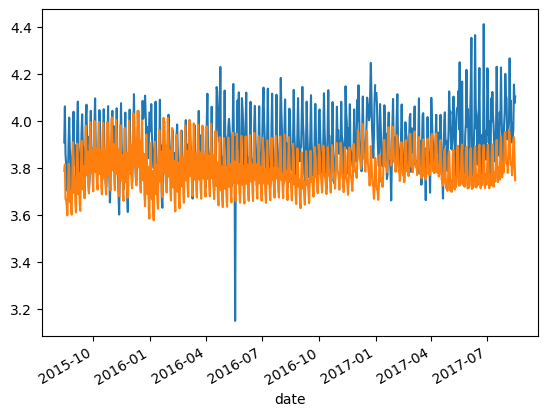

In [28]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()


ix = X.id.sample()
print(ix)
sample = (
    X
    .set_index('id')
    .loc[ix]
    .set_index('date')
)

np.log10(sample.sales.iloc[-365 * 2:]).plot(ax=ax)
ax.plot(sample.p.iloc[-365 * 2:])

# Predict Parameters

In [162]:
from ryan_adams import *
from tensorflow import keras


def E(*args, **kwargs):
    def wrapper(x):
        return keras.layers.Reshape((kwargs['output_dim'],))(
            keras.layers.Embedding(*args, **kwargs)(x)
        )
    return wrapper


def s(inputs):
    return Seasonality.fourier_series(*inputs)


def L(inputs):
    return LinearTrend.trend(*inputs)


features = {
    'oil_price': lambda x: x,
    'id': E(input_dim=X.id.nunique(), output_dim=3, input_length=1),
    'city': E(input_dim=X.city.nunique(), output_dim=2, input_length=1),
    'state': E(input_dim=X.state.nunique(), output_dim=1, input_length=1),
    'type': E(input_dim=X.type.nunique(), output_dim=2, input_length=1),
    'cluster': E(input_dim=X.cluster.nunique(), output_dim=3, input_length=1),
}
inputs = {
    f: keras.layers.Input((1,), name=f)
    for f in features
}
inputs['t'] = t_input = keras.layers.Input((1,), name='t')


w0 = keras.layers.Concatenate(name='w0')([
    σ(inputs[f])
    for f, σ in features.items()
])


for _ in range(2):
    w0 = keras.layers.Dense(10, activation='relu')(
        keras.layers.BatchNormalization()(w0)
    )

z = []
for i, (p, n) in enumerate([(365.25, 10.), (7., 3.)]):
    a_n, b_n = keras.layers.Dense(n)(w0), keras.layers.Dense(n)(w0)
    z.append(
        keras.layers.Lambda(s, name=f'seasonality_{i}')([a_n, b_n, n, p, t_input])
    )

if True:
    m = keras.layers.Dense(1)(w0)
    k = keras.layers.Dense(1)(w0)
    δ = keras.layers.Reshape((1, 20))(
        keras.layers.Dense(20, kernel_regularizer='l1')(w0)
    )
    s = LinearTrend.changepoints(t_range, .8, 20)
    z.append(
        keras.layers.Lambda(L, name='trend')([m, k, δ, t_input, s])
    )

z = keras.layers.Concatenate()(z)
z = keras.layers.Dense(5, activation='relu')(z)
z = keras.layers.Dense(1, activation='softplus')(z)

model_f = keras.models.Model(
    inputs=list(inputs.values()),
    outputs=z
)

In [163]:
model_f.compile(loss='mse', optimizer='adam', metrics=keras.metrics.RootMeanSquaredError())

In [164]:
model_f.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 id (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 city (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 state (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 type (InputLayer)              [(None, 1)]          0           []                               
                                                                                           

In [165]:
model_f.fit(
    X[['id', 't', 'oil_price', 'city', 'state', 'type', 'cluster']].to_dict('series'), np.log10(X.sales+1),
    batch_size=32,
    epochs=20
)

Epoch 1/20
2842/2842 [==============================] - 9s 2ms/step - loss: 1.5558 - root_mean_squared_error: 1.1141
Epoch 2/20
2842/2842 [==============================] - 7s 2ms/step - loss: 0.5320 - root_mean_squared_error: 0.5790
Epoch 3/20
2842/2842 [==============================] - 7s 2ms/step - loss: 0.4295 - root_mean_squared_error: 0.5387
Epoch 4/20
2842/2842 [==============================] - 7s 2ms/step - loss: 0.3819 - root_mean_squared_error: 0.5191
Epoch 5/20
2842/2842 [==============================] - 7s 2ms/step - loss: 0.3590 - root_mean_squared_error: 0.5141
Epoch 6/20
2842/2842 [==============================] - 8s 3ms/step - loss: 0.3474 - root_mean_squared_error: 0.5151
Epoch 7/20
2842/2842 [==============================] - 7s 2ms/step - loss: 0.4104 - root_mean_squared_error: 0.5837
Epoch 8/20
2842/2842 [==============================] - 7s 2ms/step - loss: 0.3466 - root_mean_squared_error: 0.5267
Epoch 9/20
2842/2842 [==============================] - 9s 3ms/s

## Predict

In [166]:
X['p'] = model_f.predict(X[['id', 't', 'oil_price', 'city', 'state', 'type', 'cluster']].to_dict('series'))

2842/2842 [==============================] - 4s 1ms/step


65985    39
Name: id, dtype: int64


/Users/dantegates/virtualenvs/v3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


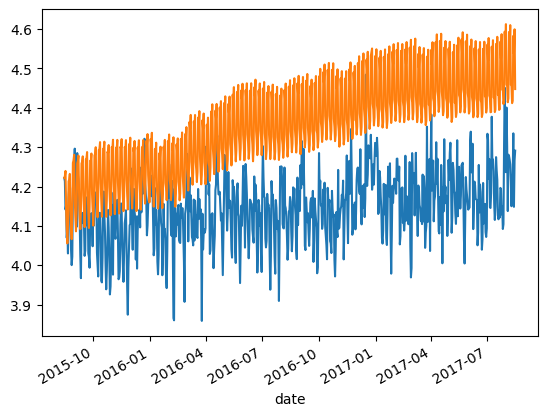

In [185]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()


ix = X.id.sample()
print(ix)
sample = (
    X
    .set_index('id')
    .loc[ix]
    .set_index('date')
)

np.log10(sample.sales.iloc[-365 * 2:]).plot(ax=ax)
ax.plot(sample.p.iloc[-365 * 2:])